In [1]:
.libPaths("/home/groups/candes/Software/miniconda2/envs/ukb/lib/R/library")
suppressMessages(library(tidyverse))
suppressMessages(library(superheat))
suppressMessages(library(bigsnpr))

scratch <- "/scratch/PI/candes/ukbiobank_tmp"

## Load phenotypes

In [2]:
# Load phenotype table
pheno.file <- sprintf("%s/phenotypes/phenotypes.tab", scratch)
Phenotypes <- read_tsv(pheno.file, col_types=cols())
Phenotypes %>% head()

FID,IID,sex,age,height,bmi,waist,dbp,sbp,platelet,⋯,diabetes,hypothyroidism,respiratory,glaucoma,PC.1,PC.2,PC.3,PC.4,PC.5,age.sq
3831650,3831650,1,63,152.0,28.7829,95.0,NA,NA,191.0,⋯,1,1,1,1,-6.79679,-5.72467,-0.8897750,1.6425900,-9.094820,3969
1585880,1585880,2,63,186.5,28.8365,107.0,90.0,131.0,169.8,⋯,1,2,1,1,-13.98880,4.52334,-0.5831590,4.2313600,8.521210,3969
1636662,1636662,2,62,173.0,21.5844,91.0,80.0,128.0,282.5,⋯,1,1,1,1,-12.96680,4.37347,-0.0836815,3.7829700,3.658520,3844
2167238,2167238,2,62,179.0,30.2737,108.5,83.0,133.5,182.8,⋯,2,1,2,1,-13.77630,3.36748,-0.5683860,0.3270650,-7.542690,3844
4462151,4462151,1,42,171.0,20.2113,78.5,84.5,124.5,294.9,⋯,1,1,1,1,-13.19000,4.46520,-0.5579330,-0.0283174,0.944134,1764
2268936,2268936,2,40,189.0,24.7194,98.5,78.5,124.0,274.4,⋯,1,1,2,1,-14.79510,4.46365,-0.5391410,1.6522700,-3.848240,1600


In [3]:
colnames(Phenotypes)

[1] "FID"            "IID"            "sex"            "age"           
 [5] "height"         "bmi"            "waist"          "dbp"           
 [9] "sbp"            "platelet"       "redcell"        "whitecell"     
[13] "eosinophil"     "redwidth"       "plateletwidth"  "cvd"           
[17] "diabetes"       "hypothyroidism" "respiratory"    "glaucoma"      
[21] "PC.1"           "PC.2"           "PC.3"           "PC.4"          
[25] "PC.5"           "age.sq"

In [8]:
# Number of cases
Phenotypes %>% select(cvd, diabetes, hypothyroidism, respiratory, glaucoma) %>% 
    summarise_all(function(x) sum(x==2))

cvd,diabetes,hypothyroidism,respiratory,glaucoma
160997,21724,24241,70345,2508


Warning message:
“Removed 2539 rows containing non-finite values (stat_boxplot).”

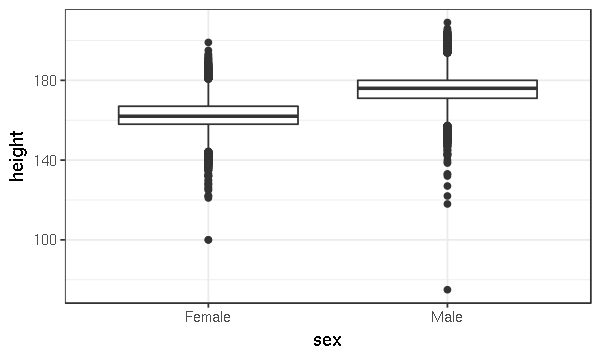

In [4]:
options(repr.plot.width=5, repr.plot.height=3)
Phenotypes %>% 
    mutate(sex=factor(sex, levels=c(1,2), labels=c("Female","Male"))) %>%
    ggplot(aes(y=height, x=sex)) + 
    geom_boxplot() +
    theme_bw()

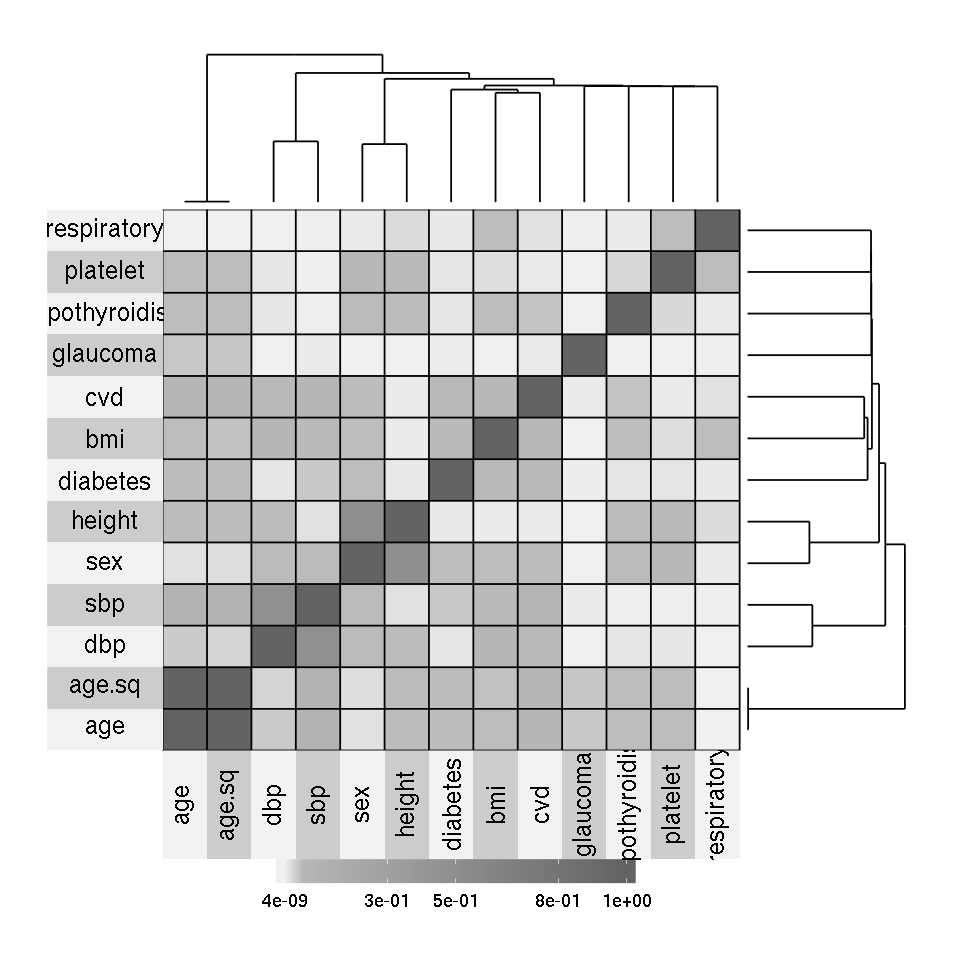

In [4]:
options(repr.plot.width=8, repr.plot.height=8)

pheno.cor <- Phenotypes %>% select(sex,age,age.sq,bmi,height,dbp,sbp,platelet,
                                   cvd,diabetes,hypothyroidism,respiratory,glaucoma) %>%
    cor(use="pairwise.complete.obs")
superheat(pheno.cor^2, heat.col.scheme = "grey", 
          row.dendrogram = TRUE, col.dendrogram = TRUE, bottom.label.text.angle = 90)

In [24]:
Phenotypes %>% select(cvd, diabetes, hypothyroidism, respiratory, glaucoma) %>% 
    summarise_all(function(x) 100*mean(x==2))

cvd,diabetes,hypothyroidism,respiratory,glaucoma
32.03665,4.32284,4.823696,13.99789,0.4990648


## Cross-referencing with genotypes

In [5]:
# Load list of subjects
fam.file <- sprintf("%s/augmented_data/Radj100_K50/ukb_gen_chr1.fam", scratch)
Subjects <- read_delim(fam.file, delim=" ", col_types=cols(),
                       col_names = c("FID", "IID", "X1", "X2", "Sex", "X3"))
cat(sprintf("Loaded list of %d individuals with knockoff genotypes.\n", nrow(Subjects)))
Subjects %>% head()

Loaded list of 350119 individuals with knockoff genotypes.


FID,IID,X1,X2,Sex,X3
5393090,5393090,0,0,1,-9
1532732,1532732,0,0,2,-9
3186275,3186275,0,0,2,-9
1277047,1277047,0,0,2,-9
5282298,5282298,0,0,2,-9
3818960,3818960,0,0,1,-9


In [6]:
Phenotypes.matched <- Subjects %>% inner_join(Phenotypes, by = c("FID", "IID"))
cat(sprintf("%d out of %d genotyped individuals (%.2f%%) have phenotype measurements.\n", 
            nrow(Phenotypes.matched), nrow(Subjects), 100*nrow(Phenotypes.matched)/nrow(Subjects)))

350079 out of 350119 genotyped individuals (99.99%) have phenotype measurements.


In [7]:
# Load list of variants on chromosome 
chr <- 1
key.file <- sprintf("%s/knockoffs/Radj100_K50/ukb_gen_chr%d.key", scratch, chr)
Variants <- read_delim(key.file, delim=" ", col_types=cols())
Variants <- Variants %>% mutate(CHR=Chr) %>% select(CHR, Variant, Position, Group, Knockoff)
colnames(Variants) <- c("CHR", "SNP", "BP", "Group", "Knockoff")

# Attach the "bigSNP" object in R session
rds.file <- sprintf("%s/augmented_data_big/ukb_gen_Radj100.rds", scratch)
if(file.exists(rds.file)){
    cat(sprintf("Found FBM in %s.\n", rds.file))
} else {
    cat(sprintf("Could not find FBM in %s.\n", rds.file))
    quit()
}

ptm <- proc.time() # Start the clock!
cat("Attaching bigSNP object... ")
obj.bigSNP <- snp_attach(rds.file)
cat("done.\n")
proc.time() - ptm # Stop the clock

# Get aliases for useful slots
G   <- obj.bigSNP$genotypes
CHR <- obj.bigSNP$map$chromosome
POS <- obj.bigSNP$map$physical.pos
SNP <- obj.bigSNP$map$marker.ID

# Make sure that the rows of the genotypes match the rows of the phenotypes
Phenotypes.matched <- Phenotypes %>%
    right_join(transmute(obj.bigSNP$fam, FID=family.ID, IID=sample.ID), by = c("FID", "IID"))

Found FBM in /scratch/PI/candes/ukbiobank_tmp/augmented_data_big/ukb_gen_Radj100.rds.
Attaching bigSNP object... done.


   user  system elapsed 
  1.613   0.030   1.784 

In [8]:
Variants %>% filter(SNP %in% c("rs574367.A","rs574367.B"))

CHR,SNP,BP,Group,Knockoff
1,rs574367.A,177873210,31785,TRUE
1,rs574367.B,177873210,31785,FALSE


In [16]:
ind.row <- which(obj.bigSNP$fam$family.ID %in% Phenotypes.matched$FID)
ind.col <- which(SNP=="rs574367.B")
data <- c()
data$y      <- Phenotypes.matched$bmi
data$G      <- G[ind.row,ind.col]
data$sex    <- Phenotypes.matched$sex
data$age    <- Phenotypes.matched$age
data$age.sq <- Phenotypes.matched$age.sq
data <- as.data.frame(data)

In [17]:
cat(sprintf("Fitting linear regression with %d variables and %d observations\n", ncol(data)-1, length(data$y)))
summary(lm(y ~ ., data))

Fitting linear regression with 4 variables and 350119 observations



Call:
lm(formula = y ~ ., data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-15.322  -3.264  -0.748   2.416  48.061 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 17.9757418  0.4035756   44.54   <2e-16 ***
G            0.2310752  0.0140039   16.50   <2e-16 ***
sex          0.7865669  0.0162141   48.51   <2e-16 ***
age          0.2718813  0.0147029   18.49   <2e-16 ***
age.sq      -0.0021968  0.0001323  -16.61   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.77 on 349053 degrees of freedom
  (1061 observations deleted due to missingness)
Multiple R-squared:  0.01054,	Adjusted R-squared:  0.01053 
F-statistic: 929.9 on 4 and 349053 DF,  p-value: < 2.2e-16


## Height

[1] "FID"            "IID"            "sex"            "age"           
 [5] "height"         "bmi"            "waist"          "dbp"           
 [9] "sbp"            "platelet"       "redcell"        "whitecell"     
[13] "eosinophil"     "redwidth"       "plateletwidth"  "cvd"           
[17] "diabetes"       "hypothyroidism" "respiratory"    "glaucoma"      
[21] "PC.1"           "PC.2"           "PC.3"           "PC.4"          
[25] "PC.5"

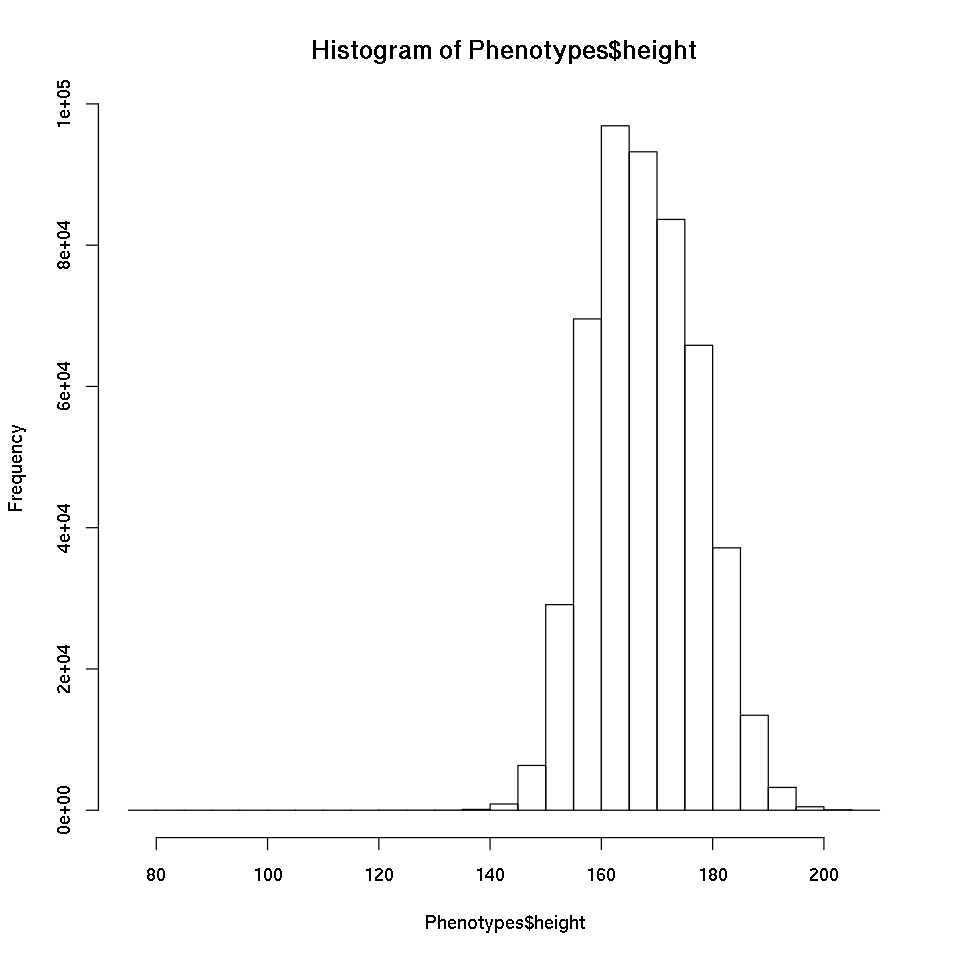

In [42]:
colnames(Phenotypes)
hist(Phenotypes$height)